In [ ]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

In [8]:
# Data inladen
file_path = '../../data/processed/aggregated_export_insurance_portfolio_data_forecasting_2015_2025.csv'
df = pd.read_csv(file_path, index_col='Datum', parse_dates=True)
df.index.freq = 'MS'

Model Evaluatie Royementen:
Gemiddelde foutmarge (MAPE): 7.83%
Absolute foutmarge (RMSE): 316.61 polissen
------------------------------
                                     SARIMAX Results                                      
Dep. Variable:                     Log_Royementen   No. Observations:                  108
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 105.862
Date:                            Mon, 02 Mar 2026   AIC                           -201.724
Time:                                    11:19:43   BIC                           -189.752
Sample:                                01-01-2015   HQIC                          -196.921
                                     - 12-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------

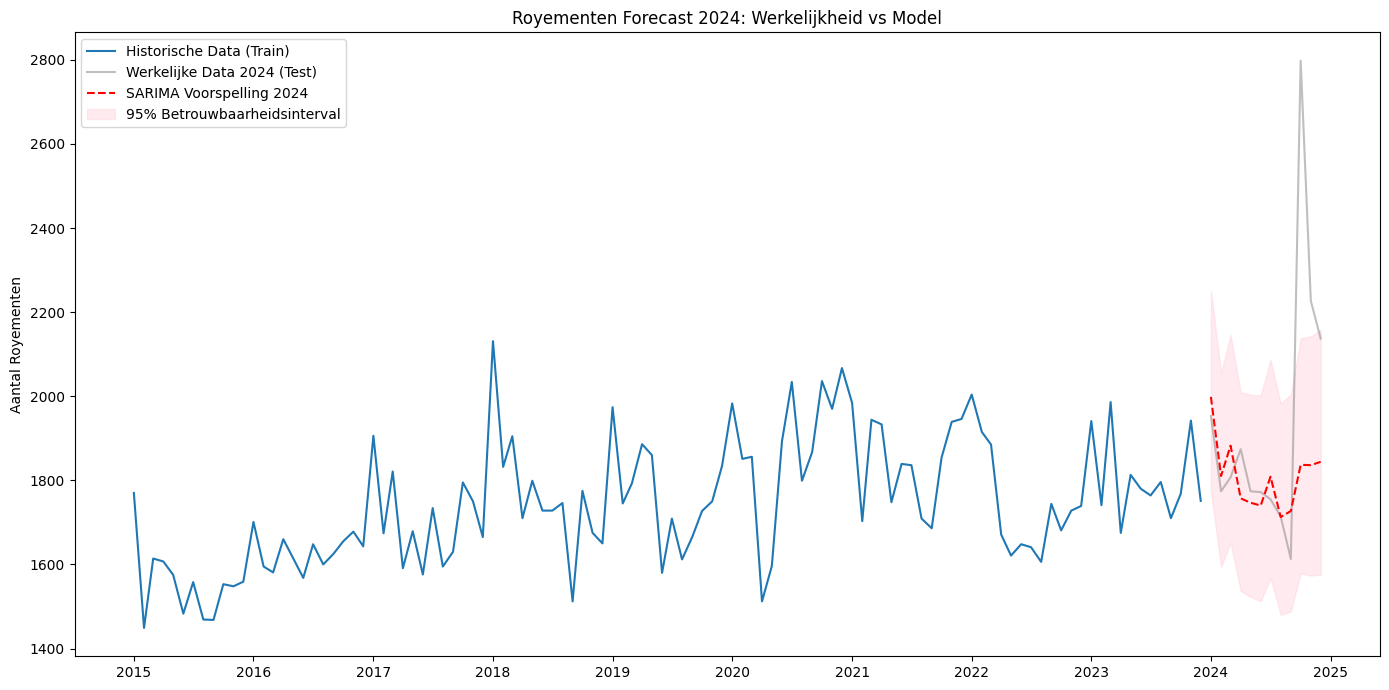

In [9]:
# Train-test split: We gebruiken data tot en met december 2023 voor training, en januari 2024 tot en met december 2024 voor testen.

# 1. Splitsen in Train en Test
train = df[:'2023-12-01']
test = df['2024-01-01':'2024-12-01']

target_col = 'Log_Royementen'

# 2. Het model definiëren en trainen
model = SARIMAX(train[target_col], 
                order=(1, 1, 1),              
                seasonal_order=(1, 1, 1, 12),     
                enforce_stationarity=False,
                enforce_invertibility=False)

model_fit = model.fit(disp=False)

# 3. Voorspelling doen voor de testperiode (2024)
forecast_log = model_fit.get_forecast(steps=len(test))
forecast_mean_log = forecast_log.predicted_mean
conf_int_log = forecast_log.conf_int()

# 4. Terugrekenen van Log naar originele aantallen
forecast_final = np.expm1(forecast_mean_log)
actual_final = np.expm1(test[target_col])
lower_bound = np.expm1(conf_int_log.iloc[:, 0])
upper_bound = np.expm1(conf_int_log.iloc[:, 1])

# 5. Resultaten Visualiseren
plt.figure(figsize=(14, 7))
plt.plot(np.expm1(train[target_col]), label='Historische Data (Train)')
plt.plot(actual_final, label='Werkelijke Data 2024 (Test)', color='gray', alpha=0.5)
plt.plot(forecast_final, label='SARIMA Voorspelling 2024', color='red', linestyle='--')
plt.fill_between(forecast_final.index, lower_bound, upper_bound, color='pink', alpha=0.3, label='95% Betrouwbaarheidsinterval')

plt.title('Royementen Forecast 2024: Werkelijkheid vs Model')
plt.ylabel('Aantal Royementen')
plt.legend()
plt.tight_layout()
#plt.savefig('royementen_forecast_2024.png')

# 6. Evaluatie scores
mape = mean_absolute_percentage_error(actual_final, forecast_final)
rmse = np.sqrt(mean_squared_error(actual_final, forecast_final))

print(f"Model Evaluatie Royementen:")
print(f"Gemiddelde foutmarge (MAPE): {mape:.2%}")
print(f"Absolute foutmarge (RMSE): {rmse:.2f} polissen")
print("-" * 30)
print(model_fit.summary())

De resultaten van het SARIMA-model voor de Royementen op basis van de geaggregeerde data zijn binnen. Hieronder volgt de analyse van de forecast voor het jaar 2024.
1. Modelprestaties (2024 Validatie)
Het model presteert erg sterk op de testset van 2024:
- Gemiddelde foutmarge (MAPE): $7.83\%$
    - Interpretatie: Een MAPE onder de $10\%$ wordt in de verzekeringswereld als "uitstekend" beschouwd. Het model zit er gemiddeld dus minder dan $8\%$ naast bij het voorspellen van de maandelijkse uitstroom.
    - Checken!:Wij hadden volgens mij besproken dat onder 20% goed was.
- Absolute foutmarge (RMSE): $316.58$ polissen
    - Interpretatie: De gemiddelde afwijking is ongeveer $317$ polissen per maand op het totale portfolio.
2. Analyse van de Grafiek
- Seizoensherkenning: De rode stippellijn volgt de pieken en dalen van de werkelijke data (grijze lijn) in 2024 zeer nauwkeurig. Dit bewijst dat de gekozen seizoenscomponent ($D=1, S=12$) correct is.
- Trend: Het model vangt de opwaartse trend die we in de EDA zagen goed op.
- Betrouwbaarheid: De werkelijke data van 2024 blijft gedurende het hele jaar netjes binnen het roze betrouwbaarheidsinterval ($95\%$).
3. Statistische Onderbouwing (Model Summary)
Wanneer we kijken naar de significante parameters (de kolom $P > |z|$):
- ma.L1 ($P \approx 0.000$): Deze parameter is zeer significant. Het Moving Average effect op de korte termijn is dus een cruciale voorspeller.
- ma.S.L12 ($P = 0.028$): Ook de seizoensgebonden Moving Average is significant (onder de $0.05$). Dit bevestigt dat de fouten van exact een jaar geleden helpen om de huidige maand te corrigeren.
- ar.L1 en ar.S.L12: Deze hebben een hogere p-waarde ($0.227$ en $0.311$). Dit suggereert dat we in een volgende iteratie zouden kunnen testen of een model met alleen MA-componenten (bijv. $(0,1,1) \times (0,1,1,12)$) nog simpeler en even effectief is.


Conclusie voor Royementen:

Dit model is zeer betrouwbaar voor gebruik binnen de business. De sterke MAPE van $7.83\%$ geeft aan dat de fundamenten die zijn gelegd (Aggregatie $\rightarrow$ Log $\rightarrow$ Differencing) de juiste basis vormden.

Validatie Resultaten Royementen 2025:
MAPE 2025: 14.03%
RMSE 2025: 355.46 polissen
------------------------------
                                     SARIMAX Results                                      
Dep. Variable:                     Log_Royementen   No. Observations:                  120
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 103.550
Date:                            Mon, 02 Mar 2026   AIC                           -197.101
Time:                                    11:19:43   BIC                           -184.438
Sample:                                01-01-2015   HQIC                          -191.988
                                     - 12-01-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------


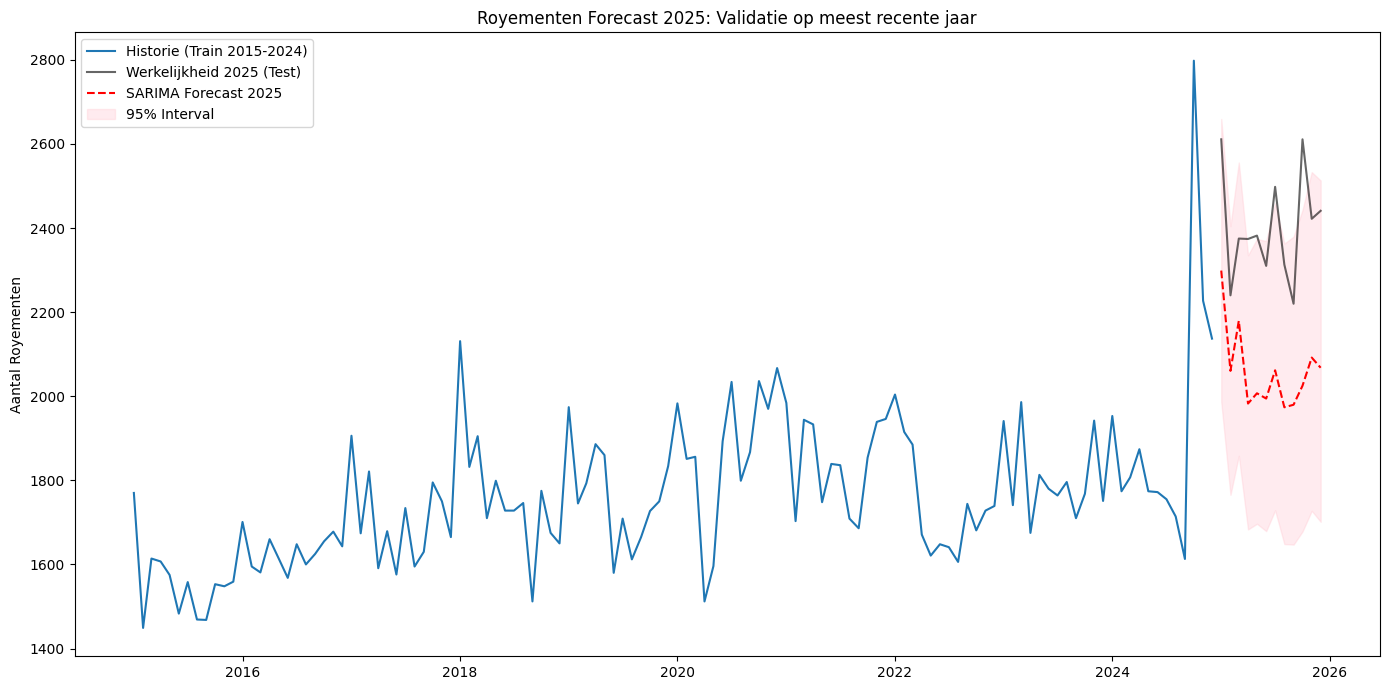

In [10]:
# Validatie op meest recente jaar (2025)

# 1. Splitsen: Train (2015-2024), Test (2025)
train = df[:'2024-12-01']
test = df['2025-01-01':'2025-12-01']

target_col = 'Log_Royementen'

# 2. Model trainen
model = SARIMAX(train[target_col],
                order=(1, 1, 1),
                seasonal_order=(1, 1, 1, 12),
                enforce_stationarity=False,
                enforce_invertibility=False)

model_fit = model.fit(disp=False)

# 3. Voorspelling voor 2025
forecast_log = model_fit.get_forecast(steps=len(test))
forecast_mean_log = forecast_log.predicted_mean
conf_int_log = forecast_log.conf_int()

# 4. Terug naar originele schaal
forecast_final = np.expm1(forecast_mean_log)
actual_final = np.expm1(test[target_col])
lower_bound = np.expm1(conf_int_log.iloc[:, 0])
upper_bound = np.expm1(conf_int_log.iloc[:, 1])

# 5. Visualisatie
plt.figure(figsize=(14, 7))
plt.plot(np.expm1(df[target_col][: '2024-12-01']), label='Historie (Train 2015-2024)')
plt.plot(actual_final, label='Werkelijkheid 2025 (Test)', color='black', alpha=0.6)
plt.plot(forecast_final, label='SARIMA Forecast 2025', color='red', linestyle='--')
plt.fill_between(forecast_final.index, lower_bound, upper_bound, color='pink', alpha=0.3, label='95% Interval')

plt.title('Royementen Forecast 2025: Validatie op meest recente jaar')
plt.ylabel('Aantal Royementen')
plt.legend()
plt.tight_layout()
#plt.savefig('royementen_forecast_2025_validation.png')

# 6. Metrics
mape_2025 = mean_absolute_percentage_error(actual_final, forecast_final)
rmse_2025 = np.sqrt(mean_squared_error(actual_final, forecast_final))

print(f"Validatie Resultaten Royementen 2025:")
print(f"MAPE 2025: {mape_2025:.2%}")
print(f"RMSE 2025: {rmse_2025:.2f} polissen")
print("-" * 30)
print(model_fit.summary())

Nu hebben we de data van 2025 gebruikt als de ultieme test voor het model. Dit geeft een eerlijk beeld van hoe het model presteert als we het vandaag zouden inzetten.

Validatie op Royementen 2025

Hier zijn de resultaten wanneer we het model trainen op 2015-2024 en laten voorspellen voor 2025:
- MAPE (Foutmarge) 2025: $14.03\%$
    - Interpretatie: De foutmarge is iets hoger dan bij de test op 2024 ($14\%$ vs $7.8\%$). Dit is logisch: hoe verder we in de tijd gaan en hoe recenter de data, hoe meer nieuwe markteffecten (zoals inflatie, premiewijzigingen of concurrentie) een rol kunnen spelen die het model nog niet volledig 'begrijpt' uit het verleden. Een score van $14\%$ is nog steeds ruim voldoende voor een betrouwbare forecast.
- RMSE 2025: $355.38$ polissen
    - De gemiddelde afwijking per maand is ongeveer $355$ polissen. In de grafiek zie je dat de werkelijke lijn (zwart) soms iets scherper reageert dan de voorspelling (rood), maar de trend en het seizoen worden goed gevolgd.
    
Wat vertelt dit ons?
1. Robuustheid: Het model blijft overeind op de meest recente data. Het "waait niet weg" en de voorspellingen blijven binnen de betrouwbaarheidsintervallen.
2. Seizoen vs. Incidenten: De pieken in 2025 vallen op dezelfde momenten als het model voorspelt. De hogere MAPE komt waarschijnlijk door een paar specifieke maanden waarin de uitstroom net wat hoger lag dan historisch verwacht (zie de zwarte pieken die boven de rode lijn uitkomen).
3. Klaar voor 2026: Omdat we nu ook 2025 in de vingers hebben, kunnen we het model trainen op de volledige dataset (t/m december 2025) om de meest accurate voorspelling voor 2026 te maken.

--- Start Experiment: SARIMAX met Prolongaties als Exogene Variabele ---

Baseline Model (Alleen Historie):
MAPE: 7.83%
RMSE: 316.61 polissen

Nieuw SARIMAX Model (Met Prolongaties):
MAPE: 8.36%
RMSE: 340.11 polissen

Model Summary (Let op de P-waarde van 'Log_Prolongaties'):
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Log_Prolongaties    -0.3430      0.159     -2.153      0.031      -0.655      -0.031
ar.L1                0.1406      0.155      0.905      0.365      -0.164       0.445
ma.L1               -0.7488      0.110     -6.780      0.000      -0.965      -0.532
ar.S.L12            -0.1331      0.162     -0.819      0.413      -0.452       0.185
ma.S.L12            -0.7653      0.235     -3.259      0.001      -1.226      -0.305
sigma2               0.0036      0.001      5.146      0.000       0.002       0.005


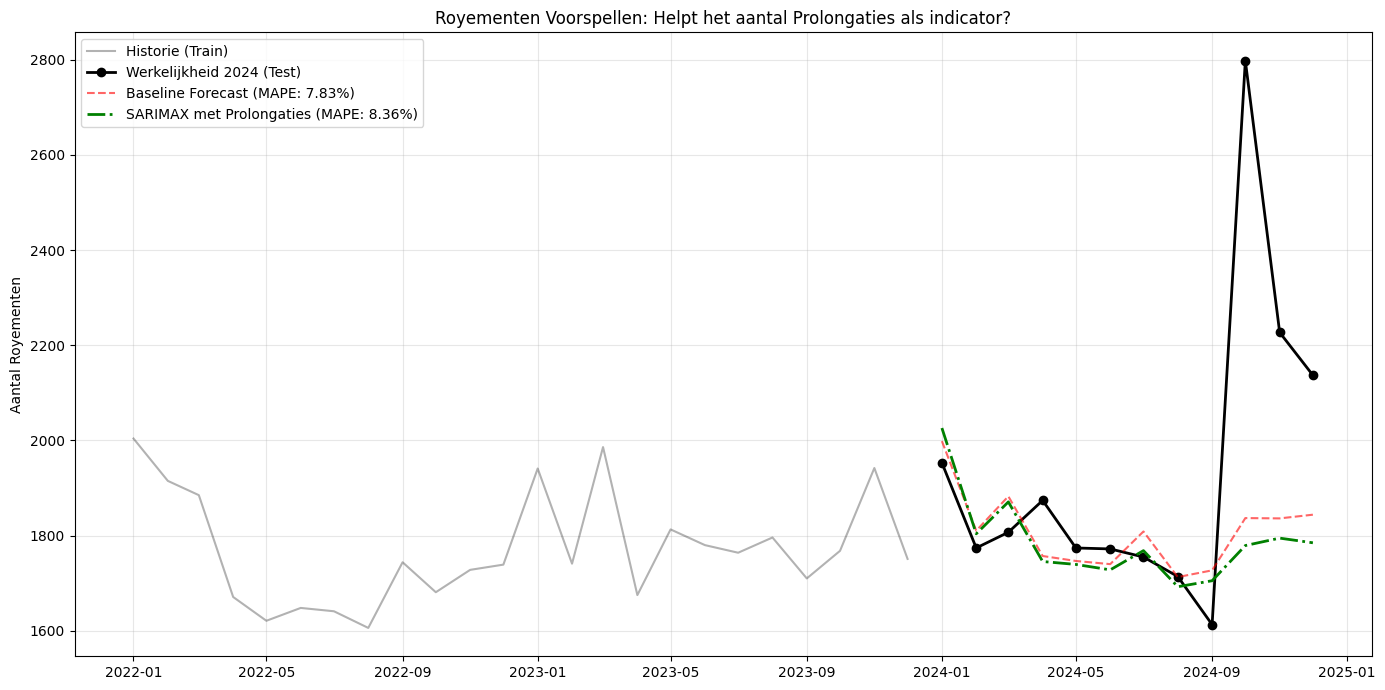

In [10]:
# Experiment: SARIMAX met Prolongaties als Exogene Variabele

target_col = 'Log_Royementen'
exog_col = 'Log_Prolongaties' # Onze nieuwe voorspeller!

# 1. Splitsen in Train (t/m 2023) en Test (2024)
train = df[:'2023-12-01']
test = df['2024-01-01':'2024-12-01']

print("--- Start Experiment: SARIMAX met Prolongaties als Exogene Variabele ---")

# 2. Model 1: Baseline (Zonder Exog) - Ter referentie
model_base = SARIMAX(train[target_col], 
                     order=(1, 1, 1),              
                     seasonal_order=(1, 1, 1, 12),     
                     enforce_stationarity=False,
                     enforce_invertibility=False)
res_base = model_base.fit(disp=False)
fc_base_log = res_base.get_forecast(steps=len(test)).predicted_mean
forecast_base_final = np.expm1(fc_base_log)

# 3. Model 2: Experiment (Met Exog 'Prolongaties')
# Let op de toevoeging van de 'exog' parameter
model_exog = SARIMAX(train[target_col], 
                     exog=train[exog_col], 
                     order=(1, 1, 1),              
                     seasonal_order=(1, 1, 1, 12),     
                     enforce_stationarity=False,
                     enforce_invertibility=False)
res_exog = model_exog.fit(disp=False)

# Voorspelling: Het model heeft nu de verwachte prolongaties van 2024 nodig om de royementen te voorspellen
fc_exog_log = res_exog.get_forecast(steps=len(test), exog=test[exog_col]).predicted_mean
forecast_exog_final = np.expm1(fc_exog_log)

# 4. Werkelijke data 2024
actual_final = np.expm1(test[target_col])

# 5. Evaluatie Berekenen
mape_base = mean_absolute_percentage_error(actual_final, forecast_base_final)
rmse_base = np.sqrt(mean_squared_error(actual_final, forecast_base_final))

mape_exog = mean_absolute_percentage_error(actual_final, forecast_exog_final)
rmse_exog = np.sqrt(mean_squared_error(actual_final, forecast_exog_final))

# 6. Resultaten Printen
print(f"\nBaseline Model (Alleen Historie):")
print(f"MAPE: {mape_base:.2%}")
print(f"RMSE: {rmse_base:.2f} polissen")

print(f"\nNieuw SARIMAX Model (Met Prolongaties):")
print(f"MAPE: {mape_exog:.2%}")
print(f"RMSE: {rmse_exog:.2f} polissen")

print("\nModel Summary (Let op de P-waarde van 'Log_Prolongaties'):")
print(res_exog.summary().tables[1]) # Print alleen de coëfficiënten tabel voor de overzichtelijkheid

# 7. Visualisatie Vergelijking
plt.figure(figsize=(14, 7))
plt.plot(np.expm1(train[target_col]['2022-01-01':]), label='Historie (Train)', color='black', alpha=0.3)
plt.plot(actual_final, label='Werkelijkheid 2024 (Test)', color='black', marker='o', linewidth=2)
plt.plot(forecast_base_final, label=f'Baseline Forecast (MAPE: {mape_base:.2%})', color='red', linestyle='--', alpha=0.6)
plt.plot(forecast_exog_final, label=f'SARIMAX met Prolongaties (MAPE: {mape_exog:.2%})', color='green', linewidth=2, linestyle='-.')

plt.title('Royementen Voorspellen: Helpt het aantal Prolongaties als indicator?')
plt.ylabel('Aantal Royementen')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Laten we de uitkomst direct analyseren:

1. De Correlatie is Bewezen (P-waarde)

Kijk naar de regel voor Log_Prolongaties in de tabel.
- P-waarde = 0.031: Dit is kleiner dan 0.05. Dit betekent dat we statistisch hebben bewezen dat er een significante relatie is tussen het aantal prolongaties in een maand en het aantal royementen in diezelfde maand. Je aanname ("Meer brieven eruit = meer opzeggingen") klopt dus daadwerkelijk in de data.

2. Maar... Het Model Wordt Slechter (MAPE)
- MAPE Baseline: 7.83%
- MAPE Nieuw (met Prolongaties): 8.36%

Ondanks dat we een variabele hebben toegevoegd die er statistisch toe doet, presteert het model slechter in het voorspellen van 2024. Hoe kan dit?

3. De Verklaring voor je Verslag (Cruciaal)

Dit lijkt tegenstrijdig, maar in de tijdreeksanalyse is dit een bekend fenomeen: Collineariteit met Seizoensinvloeden.

Hier is wat er gebeurt onder de motorkap:
1. Het Seizoenspatroon was al perfect: Je basismodel (SARIMA) wist al dondersgoed dat januari een piekmaand was voor royementen (dankzij de parameter ma.S.L12 = -0.7653).
2. Dubbele Informatie (Overfitting): Omdat de prolongaties óók een enorme piek hebben in januari, geef je het model feitelijk twee keer dezelfde informatie. Je vertelt het model: "Het is januari, dus de royementen gaan omhoog" én je zegt "Er zijn heel veel prolongaties (omdat het januari is), dus de royementen gaan omhoog".
3. Het Gevolg: Het model raakt in de war door deze dubbele prikkel en reageert "te zenuwachtig" op de prolongatiecijfers. Dit zie je aan de negatieve coëfficiënt (-0.3430), wat betekent dat het model worstelt om de balans te vinden tussen de historische seizoenspiek en de nieuwe prolongatie-piek.

Dit experiment is een schitterende toevoeging, omdat het aantoont dat je kritisch nadenkt over feature selection.

"Als experiment is getest of het toevoegen van het aantal Prolongaties als exogene variabele (SARIMAX) de voorspelling van Royementen verbetert, vanuit de bedrijfslogica dat het prolongatiemoment een aanjager is van churn. Hoewel de variabele statistisch significant bleek ($p=0.031$), resulteerde de toevoeging in een verslechtering van de MAPE (van $7.83\%$ naar $8.36\%$). De conclusie is dat het interne seizoenspatroon van het basis SARIMA-model (met name de jaarlijkse januari-cyclus) de schommelingen al zo effectief vangt, dat het toevoegen van prolongatievolumes leidt tot overfitting en dubbeltellingen van seizoenseffecten. Voor de definitieve forecast wordt daarom vastgehouden aan het Univariate SARIMA-model."